In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from sklearn.metrics import confusion_matrix 
import numpy as np 
import matplotlib.pyplot as plt 

from glob import glob
import itertools
from keras.callbacks import ModelCheckpoint

In [2]:
#Config

#re-size all the images to this 
IMAGE_SIZE=[100,100]
epochs=16
batch_size=128

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2022-10-21 09:00:37--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M   292KB/s    in 9m 13s  

2022-10-21 09:09:50 (337 KB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [4]:
!ls

fruits-360.zip	sample_data


In [5]:
!unzip -nq fruits-360.zip

In [6]:
train_path = "fruits-360/Training"
valid_path = "fruits-360/Validation"

In [7]:
# useful for getting the number of files : 
image_files= glob(train_path+"/*/*.jp*g")
valid_images_files= glob(valid_path+"/*/*.jp*g")

In [8]:
#useful for getting the number of classes : 
folders = glob(train_path+"/*")
print("There are ", len(folders)," classes.")

There are  60  classes.


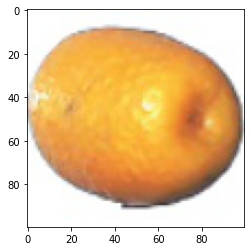

In [9]:
#Display an image : 
plt.imshow(image.load_img(np.random.choice(image_files)))

#Model

In [10]:
res=ResNet50(input_shape=IMAGE_SIZE+[3], weights="imagenet", include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [11]:
for layer in res.layers : 
    layer.trainable= False

In [12]:
#Adding our layers : 
x=Flatten()(res.output)
x = Dense(1000, activation="relu")(x)#example 
predictions = Dense(len(folders),activation="softmax")(x)


In [13]:
#Building the final model : 
model= Model(res.input, predictions)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [15]:
model.compile(optimizer="adam",loss = "sparse_categorical_crossentropy", metrics= ["accuracy"])

## Data augmentation  

In [16]:
#Create an instance of data generator : 
train_gen=  ImageDataGenerator( 
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen =ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [17]:
#Testing the generator to see how it works : 
#get label mapping for confusion matrix plot later : 

test_gen=val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items(): 
    labels[v] = k


Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

min -123.68 max :  151.061


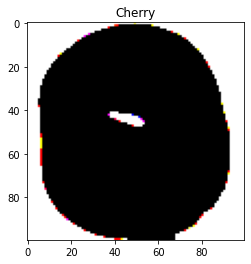

In [18]:
# Colors are strange because resnet weights are BGR : 
for x, y in test_gen : 
    print("min", x[0].min(), "max : ",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

### Creating generators : 

In [19]:
train_generator = train_gen.flow_from_directory(
    train_path, 
    target_size=IMAGE_SIZE, 
    shuffle = True, 
    batch_size=batch_size, 
    class_mode= "sparse"
)

valid_generator= val_gen.flow_from_directory(
    valid_path, 
    target_size=IMAGE_SIZE, 
    shuffle=False, 
    batch_size=batch_size, 
    class_mode="sparse"
)

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [21]:
#Callback  : 
filepath = 'model2.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor="val_accuracy",
                             verbose=1, 
                             save_best_only=True,
                             mode="max")


callbacks= [checkpoint]

In [ ]:
r = model.fit(train_generator, 
              validation_data=valid_generator, 
              epochs=epochs, 
              steps_per_epoch = len(image_files) // batch_size, 
              validation_steps = len(valid_images_files) // batch_size,
              callbacks = callbacks)

Epoch 1/16
224/224 [==============================] - ETA: 0s - loss: 1.3346 - accuracy: 0.8672
Epoch 1: val_accuracy improved from -inf to 0.93781, saving model to model2.epoch01-loss0.24.hdf5
224/224 [==============================] - 107s 428ms/step - loss: 1.3346 - accuracy: 0.8672 - val_loss: 0.2405 - val_accuracy: 0.9378
Epoch 2/16
224/224 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9589
Epoch 2: val_accuracy improved from 0.93781 to 0.98021, saving model to model2.epoch02-loss0.07.hdf5
224/224 [==============================] - 94s 421ms/step - loss: 0.1442 - accuracy: 0.9589 - val_loss: 0.0699 - val_accuracy: 0.9802
Epoch 3/16
224/224 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9750
Epoch 3: val_accuracy improved from 0.98021 to 0.98271, saving model to model2.epoch03-loss0.06.hdf5
224/224 [==============================] - 94s 417ms/step - loss: 0.0895 - accuracy: 0.9750 - val_loss: 0.0621 - val_accuracy: 0.9827
Epoch 4/1

In [22]:
model.evaluate(valid_generator)

76/76 [==============================] - 10s 124ms/step - loss: 0.0102 - accuracy: 0.9979


[0.010230711661279202, 0.9979323744773865]

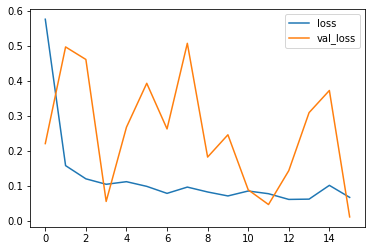

In [24]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

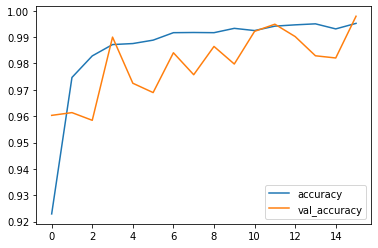

In [25]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [26]:
def get_confusion_matrix(data_path, N): 
    #we need to see the data in the same order 
    #for both predictions and targets 
    print("generating confusion matrix " , N)
    predictions=[]
    targets=[]
    i = 0 
    n_images=0
    for x, y in val_gen.flow_from_directory(
        data_path, 
        target_size= IMAGE_SIZE,
        shuffle = False, 
        batch_size= batch_size*2
    ): 
        i+=1 
        n_images+=len(y)
        if i % 50== 0 : 
            print(f'{n_images} images processed')

        p =model.predict(x)
        p= np.argmax(p, axis=1)
        y=np.argmax(y, axis=1)  
        predictions = np.concatenate((predictions, p))
        targets= np.concatenate((targets,y))
        if len(targets) >= N : 
            break
    
    cm = confusion_matrix(targets , predictions)
    return cm 

In [27]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(valid_path, len(valid_images_files))


generating confusion matrix  28736
Found 28736 images belonging to 60 classes.
8/8 [==============================] - 0s 27ms/step
12800 images processed
8/8 [==============================] - 0s 28ms/step
25600 images processed
2/2 [==============================] - 0s 24ms/step
generating confusion matrix  9673
Found 9673 images belonging to 60 classes.
7/7 [==============================] - 1s 86ms/step


In [70]:
def plot_confusion_matrix(cm, classes, normalize=False, title="confusion matrix", cmap = plt.cm.Blues):
    """This function prints and plots the confusion matrix. Normalization can be applied by setting "normalize=True".
    """
    if normalize: 
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else : 
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation="nearest", cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks,classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j]> thresh else "black"
                 )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted_label")

    plt.show()

Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


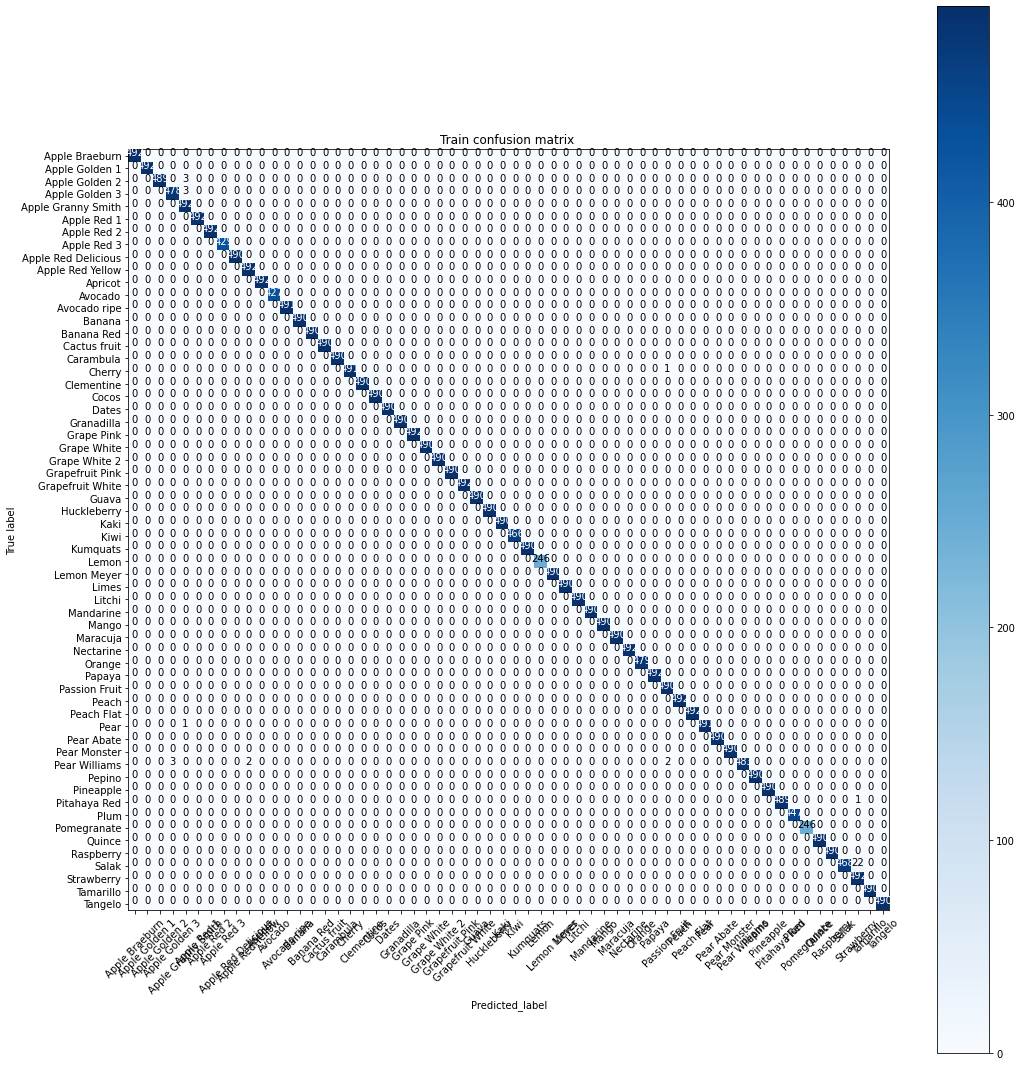

In [29]:
plot_confusion_matrix(cm, labels, title="Train confusion matrix ")

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 162 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


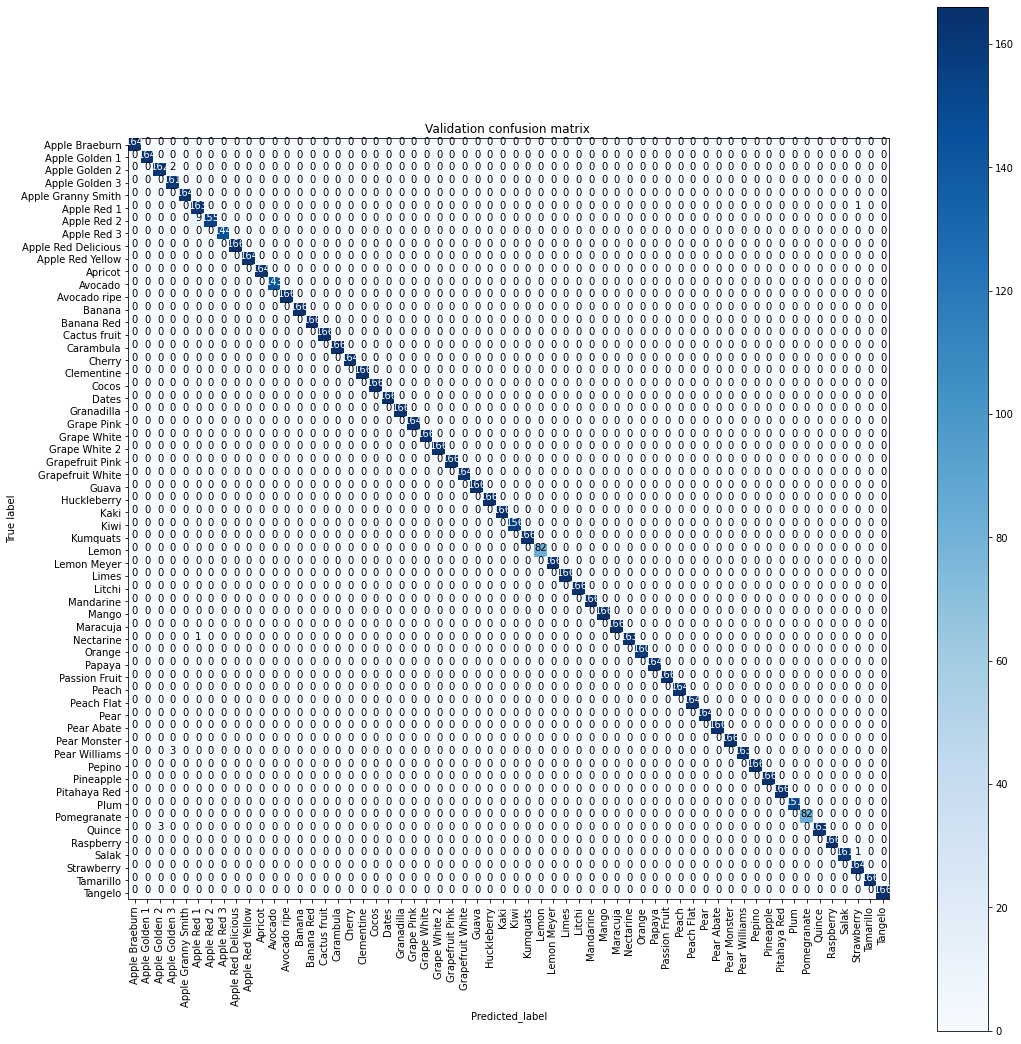

In [71]:
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix ")

#Confusion matrices of the best model : 

In [34]:
import tensorflow as tf
filepath="model.epoch16-loss0.01.hdf5"
model = tf.keras.models.load_model(filepath)

In [35]:
model.evaluate(valid_generator)

76/76 [==============================] - 10s 117ms/step - loss: 0.0102 - accuracy: 0.9979


[0.010230711661279202, 0.9979323744773865]

In [36]:
cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(valid_path, len(valid_images_files))


generating confusion matrix  28736
Found 28736 images belonging to 60 classes.
8/8 [==============================] - 0s 27ms/step
12800 images processed
8/8 [==============================] - 0s 28ms/step
25600 images processed
2/2 [==============================] - 0s 24ms/step
generating confusion matrix  9673
Found 9673 images belonging to 60 classes.
7/7 [==============================] - 1s 28ms/step


Confusion matrix, without normalization
[[492   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 489 ...   0   0   0]
 ...
 [  0   0   0 ... 492   0   0]
 [  0   0   0 ...   0 490   0]
 [  0   0   0 ...   0   0 490]]


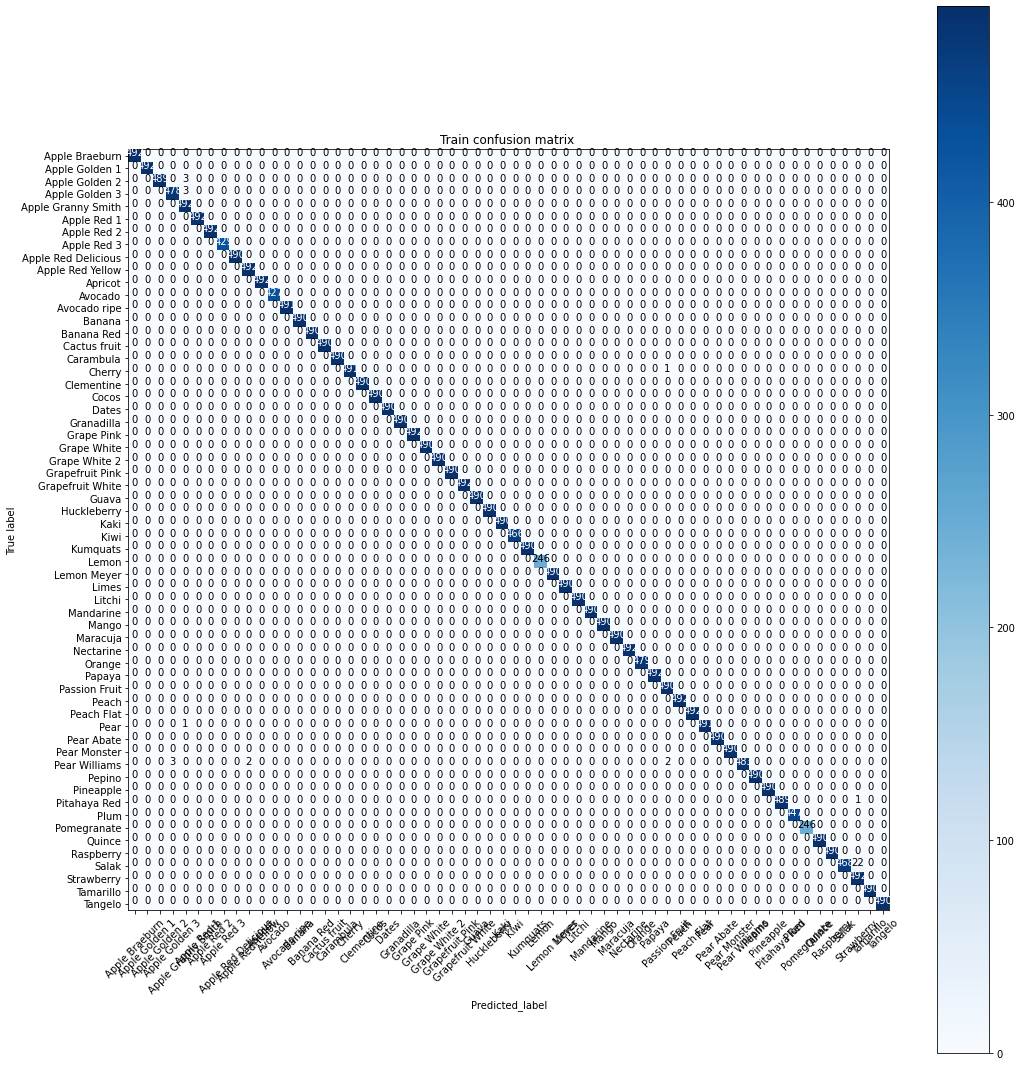

In [37]:
plot_confusion_matrix(cm, labels, title="Train confusion matrix ")

Confusion matrix, without normalization
[[164   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 162 ...   0   0   0]
 ...
 [  0   0   0 ... 164   0   0]
 [  0   0   0 ...   0 166   0]
 [  0   0   0 ...   0   0 166]]


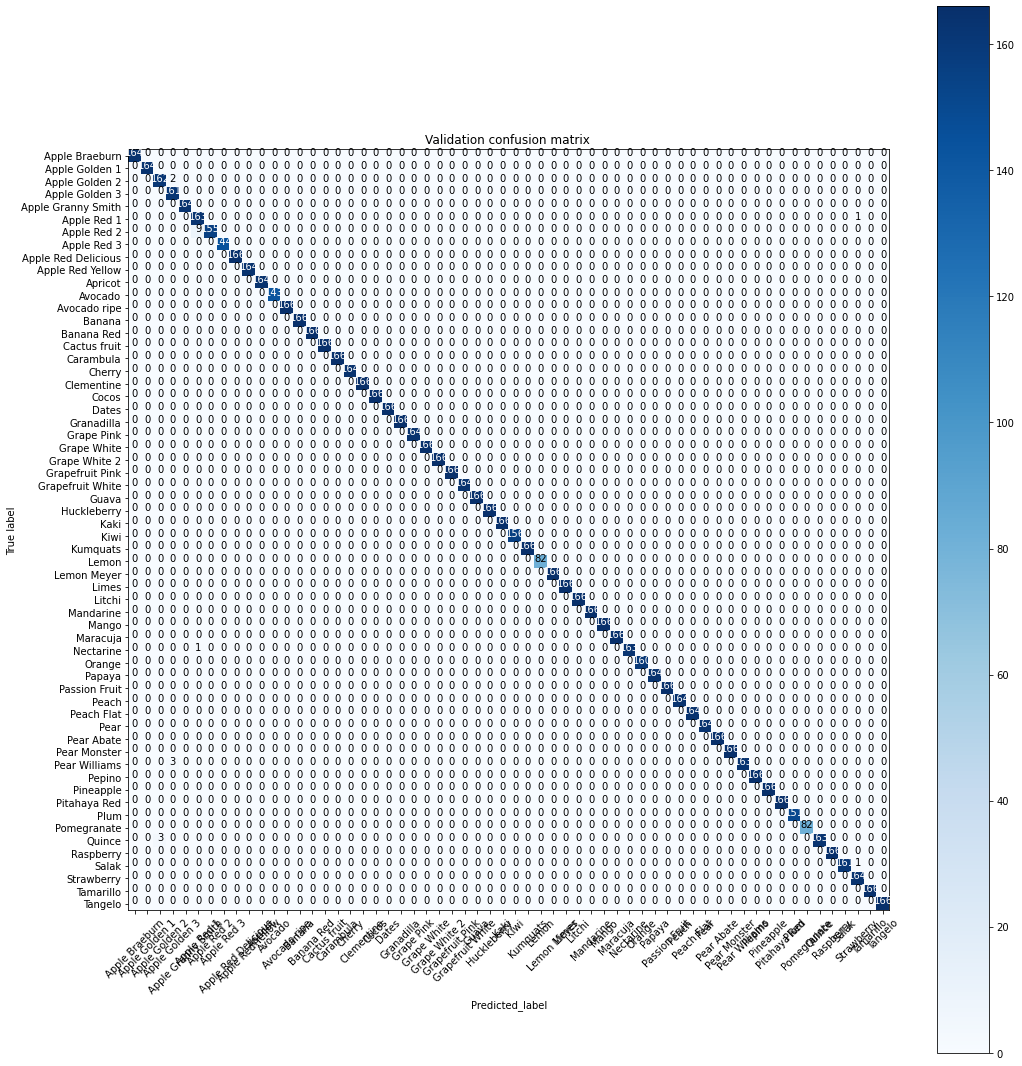

In [38]:
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix ")